#### 1. Preparation

In [1]:
# This line of code is for accessing the virtual folder '\\file'
# I mapped the path to my virtual folder as S:\
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\Grid_Ori_bigdata_005')

In [2]:
# Packages
import os
import pathlib
import datetime

import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set up main directory
main_dir = r"S:\Grid_Ori_bigdata_005"

The work below is similar to 'validation_otherfiles' but without writing out files. I separate it here for easy following

#### 2. Read DEM

In [4]:
# Using copied DEM from 'others' folder
# Read DEM file
dem_xr = xr.open_dataset(fr"{main_dir}\\dem.nc")

# Assign crs
dem_xr = dem_xr.rio.write_crs("epsg:2193", inplace=True)

# Crop by geometry domain
dem_xr_domain = dem_xr.z

#### 3. Roughness length to Manning's

In [5]:
# Building up a function to convert roughness length (Z0) to Manning's n
def zo_to_n(zo, H):
    ''' This function is to convert roughness length (Z0) to Manning's n
    Ref: https://doi.org/10.1080/15715124.2017.1411923
    '''
    return (0.41 * (H**(1/6)) * ((H/zo) - 1))/(np.sqrt(9.80665) * (1 + (H/zo) * (np.log(H/zo) - 1)))

In [6]:
# Load zo - roughness length raster file
zo_xr = xr.open_dataset(fr"{main_dir}\\zo.nc")

# Assign crs
zo_xr = zo_xr.rio.write_crs("epsg:2193", inplace=True)

# Crop by geometry domain
zo_xr_domain = zo_xr.zo

# Choose H=1 to obtain n
n_domain = zo_to_n(zo_xr_domain, 1)

#### 3. Tide flow

In [7]:
## FLOW

# New Zealand time is 12 hours ahead Universal Time Coordinated --> UTC(0) and NZST(+12)
# So to convert back to UTC, the time needs to be converted back to New Zealand time
# http://graphs.gw.govt.nz/?siteName=Waikanae%20River%20at%20Water%20Treatment%20Plant&dataSource=Flow
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", skiprows=[0], 
                          names=['DateChar', 'Flow', 'Quality'],
                          header=None)

# Get flow data
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", names=['DateChar', 'Flow', 'Quality'], skiprows=[0], header=None)
flowJan2005 = flowJan2005[['DateChar', 'Flow']]

# Convert time data
flowJan2005['DateTime'] = pd.to_datetime(flowJan2005['DateChar'], format="%m/%d/%Y %H:%M:%S", utc=False)
flowJan2005['DateTime'] = flowJan2005['DateTime'].dt.tz_localize(None)

In [8]:
# Get tide data
tideJan2005 = pd.read_csv(fr"{main_dir}\\tide.csv",
                          skiprows=np.arange(0, 9, 1),
                          names=['DateChar', 'Level'],
                          header=None)
# Convert time data
tideJan2005['DateTime'] = pd.to_datetime(tideJan2005['DateChar'], format="%Y-%m-%dT%H:%M:%SZ", utc=False)
tideJan2005['DateTime'] = tideJan2005['DateTime'].dt.tz_localize(None) # Romve timezone

In [9]:
# Convert level data
tideJan2005['Level'] = tideJan2005['Level'] - 0.11

# Convert timezone
time_change = datetime.timedelta(hours=12)
tideJan2005['DateTime'] = tideJan2005['DateTime'] + time_change

# Align flow and tide data
tide_flowJan2005 = pd.merge(tideJan2005, flowJan2005, how='outer', on='DateTime')[['DateTime', "Flow", "Level"]]
tide_flowJan2005 = tide_flowJan2005.sort_values(by='DateTime').reset_index(drop=True)
tide_flowJan2005['Level'] = tide_flowJan2005['Level'].interpolate(method='cubic')

# Select/Filter time
date_start = pd.to_datetime("2005-01-05 00:00:00")
date_end = pd.to_datetime("2005-01-07 00:00:00")

# Merge tide and flow
tide_flowJan2005 = tide_flowJan2005.loc[(tide_flowJan2005.DateTime >= "2005-01-05 00:00:00")
                                        & (tide_flowJan2005.DateTime <= "2005-01-07 00:00:00")]

Text(212.59722222222223, 0.5, 'Flow discharge ($\\frac{m^{3}}{s}$)')

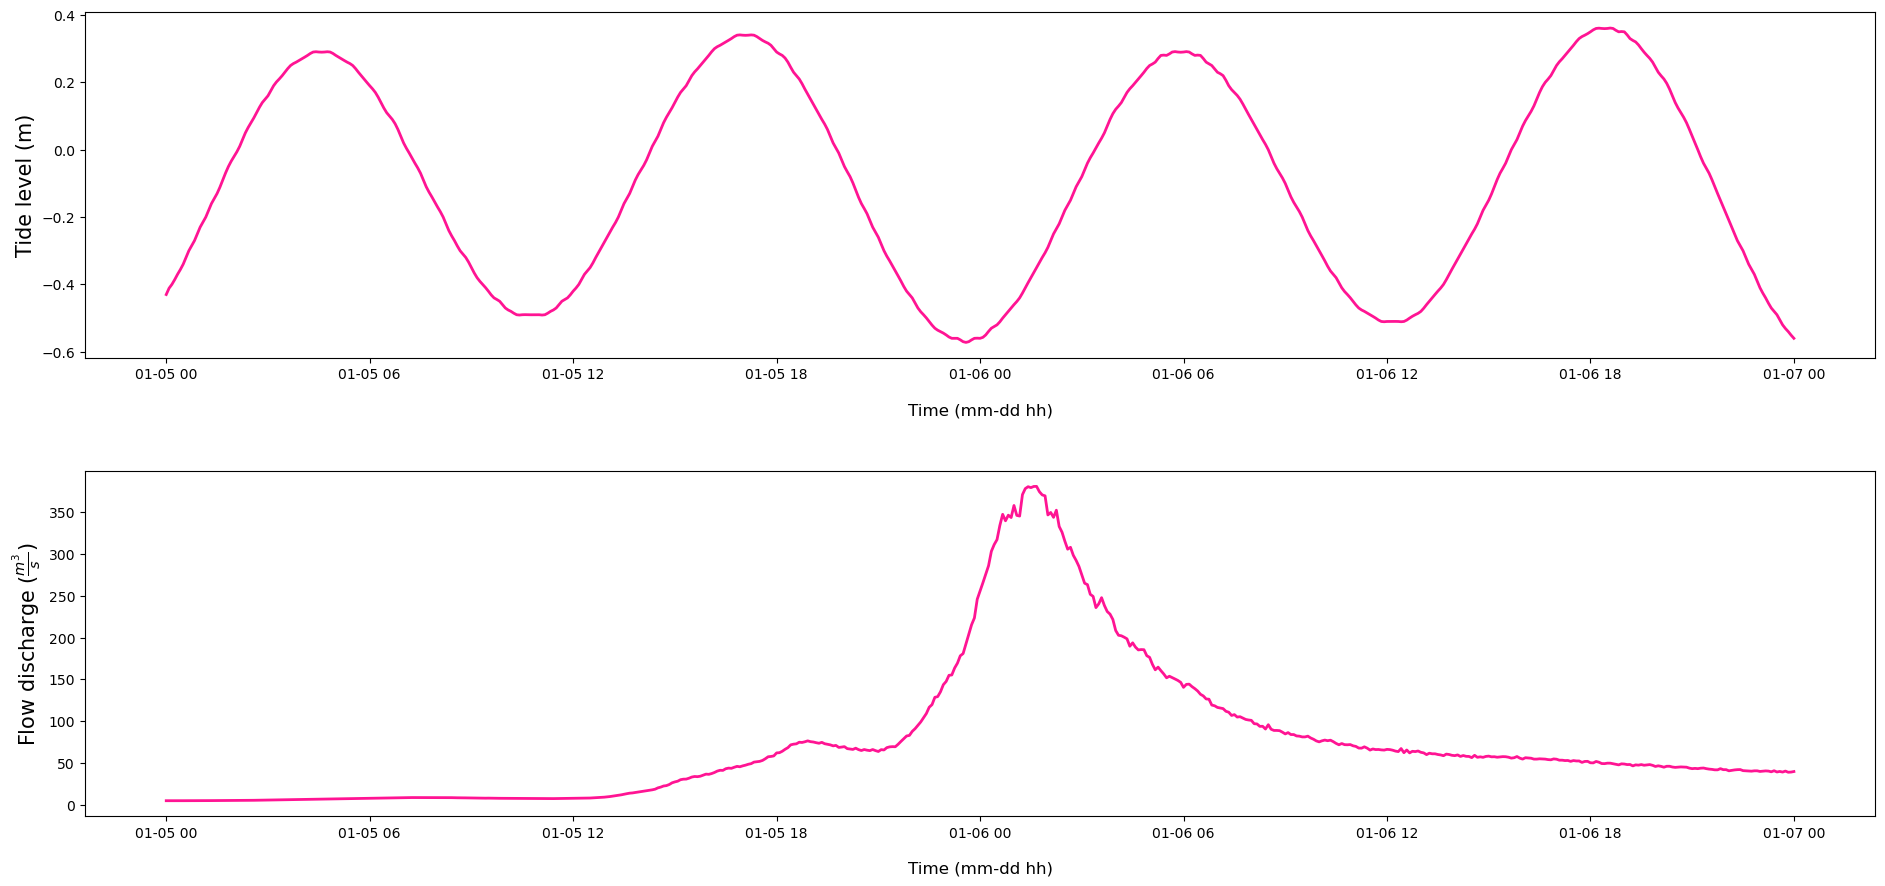

In [10]:
# Plot
fig, axes = plt.subplots(2, figsize=(20, 10))
fig.tight_layout(pad=6.0)

# Tide
axes[0].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Level, linewidth=2, color='deeppink')
axes[0].set_xlabel('Time (mm-dd hh)', fontsize=12, labelpad=15)
axes[0].set_ylabel('Tide level (m)', fontsize=15)

# Flow
axes[1].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Flow, linewidth=2, color='deeppink')
axes[1].set_xlabel('Time (mm-dd hh)', fontsize=12, labelpad=15)
axes[1].set_ylabel(r'Flow discharge ($\frac{m^{3}}{s}$)', fontsize=15)

#### 4. Startdepth

In [11]:
# Start file
startdepth = dem_xr_domain
startdepth = startdepth.where(startdepth.values <= tide_flowJan2005.Level.iloc[0], other=np.nan)
startdepth = startdepth * -1

#### 5. Sea

In [12]:
dem_xr_domain_copy = dem_xr_domain.copy(deep=True)
n_domain_copy = n_domain.copy(deep=True)
startdepth_copy = startdepth.copy(deep=True)

In [13]:
# Sea
seaarea = dem_xr_domain_copy * np.nan
seaarea = seaarea.where(dem_xr_domain_copy.values >= (np.min(tide_flowJan2005.Level)-3), other=1)

# Remove sea area
dem_xr_domain_copy = dem_xr_domain_copy.where(seaarea.values != 1, other=np.nan) # cropped DEM
n_domain_copy = n_domain_copy.where(seaarea.values != 1, other=np.nan) # Manning's n
startdepth_copy = startdepth.where(seaarea.values != 1, other=np.nan)

#### 6. Calibration

In [14]:
# Create Maning's n files
n_domain_calibration = n_domain.copy(deep=True)
n_domain_calibration = n_domain_calibration.where(seaarea.values != 1, other=np.nan)

# Get range
n_calibration_range = np.round(np.arange(0.5, 2.6, 0.1), 1)

# Create different Manning's n files
for i in n_calibration_range:
    # Get new values
    n_domain_calibration_value = n_domain_calibration * i
    
    # Write roughness
    n_domain_calibration_value = n_domain_calibration_value.rio.write_nodata(-9999, inplace=True)
    n_domain_calibration_value.rio.to_raster(fr"{main_dir}\\n_{i}.nc")
    n_domain_calibration_value = rxr.open_rasterio(fr"{main_dir}\\n_{i}.nc")
    n_domain_calibration_value.rio.to_raster(fr"{main_dir}\\n_{i}.asc")

In [15]:
# Create calibration folders
for i in n_calibration_range:
    pathlib.Path(fr"{main_dir}\\n_{i}").mkdir(parents=True, exist_ok=True)

In [16]:
# NOTICE: files 'waikanae.bci' and 'waikanae.bdy' were copied from 'others' folder
# So here I did not recreated them
# Without rain
parameters_list = [np.array([
    ('resroot', 'out'),
    ('dirroot', f'n_{i}'),
    ('saveint', 3600),
    ('massint', 100),
    ('sim_time', 172800),
    ('initial_tstep', 2),
    ('bcifile', 'waikanae.bci'),
    ('bdyfile', 'waikanae.bdy'),
    ('DEMFile', 'dem.asc'),
    ('manningfile', f'n_{i}.asc'),
    ('startfile', 'startdepth.asc')]) for i in n_calibration_range
]

# Write into text file par format
for i in range(len(n_calibration_range)):
    with open(fr"{main_dir}\\n_{n_calibration_range[i]}.par", 'w') as parameters:
        for each_parameter in range(parameters_list[i].shape[0]):
            data_parameter = parameters_list[i][each_parameter]
            text_parameter = '{0[0]:<20}{0[1]}\n'.format(data_parameter)
            parameters.write(text_parameter)
        parameters.write('acceleration\ndrain_nodata\n\n')

In [17]:
# Bat file
with open(fr"{main_dir}\\n_calibration_test.bat", 'w') as execution:
    execution.write(fr'cd {main_dir}')
    for i in n_calibration_range:
        each_n = f"\nlisflood_v8_1_0.exe -v n_{i}.par\ntimeout /t 5"
        execution.write(each_n)